## **Shuffle Generators Approach**

#### **Imports**

In [42]:

import os
import random
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import (
    models, 
    transforms,
)
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset,
)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
)


In [43]:
import torch
print("Torch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Torch Version: 2.5.1+cu121
CUDA Version: 12.1
CUDA available: True
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


#### **Dataset Class**

In [44]:
# Crop out watermark from the bottom of the image
def crop_bottom(image, px=25):
    width, height = image.size
    return image.crop((0, 0, width, height - px))

In [45]:
class AllGeneratorsDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        self.samples = []
        self.transform = transform

        for generator in root_dirs:
            for label_type in ['real', 'fake']:
                folder = os.path.join(generator, label_type)
                for file in os.listdir(folder):
                    if file.lower().endswith(('.jpg', '.png', '.webp')):
                        path = os.path.join(folder, file)
                        label = 0 if label_type == 'real' else 1
                        self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        image = crop_bottom(image)  # use your watermark crop
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_labels(self):
        return [label for _, label in self.samples]

#### **Load and Transform**

In [46]:
generators = ['DALLE_dataset', 'IMAGEN_dataset', 'SD_dataset']
base_path = '../../data'
root_dirs = [os.path.join(base_path, g) for g in generators]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = AllGeneratorsDataset(root_dirs, transform=transform)
labels = dataset.get_labels()

In [47]:
def preview_dataset(subset, num_samples=6, title="Dataset Preview"):
    from collections import Counter
    import matplotlib.pyplot as plt

    # Handle Subset (like from random_split)
    if isinstance(subset, torch.utils.data.Subset):
        dataset = subset.dataset
        indices = subset.indices
    else:
        dataset = subset
        indices = list(range(len(subset)))

    print(f"Total samples: {len(indices)}")

    # Count class distribution
    label_subset = [dataset.samples[i][1] for i in indices]
    label_names = {0: "Real", 1: "Fake"}
    counts = Counter(label_subset)

    for label, count in counts.items():
        print(f"🖼️ {label_names[label]}: {count} images")

    # Random samples from subset
    sample_indices = random.sample(indices, min(num_samples, len(indices)))
    fig, axs = plt.subplots(1, len(sample_indices), figsize=(len(sample_indices) * 3, 3))

    for i, idx in enumerate(sample_indices):
        image, label = dataset[idx]
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # unnormalize
        img_np = img_np.clip(0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(label_names[label])
        axs[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Total samples: 12000
🖼️ Real: 6000 images
🖼️ Fake: 6000 images


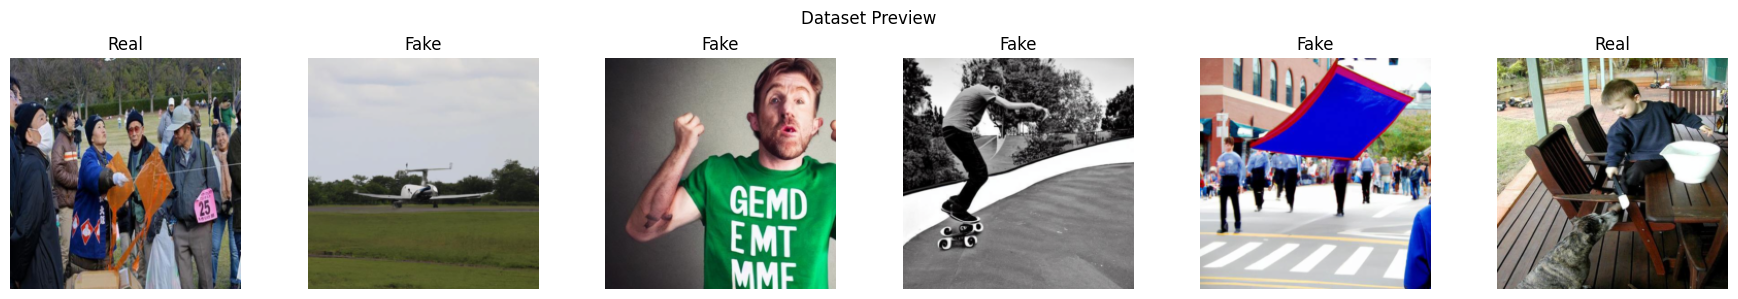

In [48]:
preview_dataset(dataset, num_samples=6)

In [49]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

In [50]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)


In [51]:
def evaluate_and_report(model, loader, device, name="Evaluation", thresholds=[0.90, 0.80, 0.70, 0.60]):
    model.eval()
    predictions, targets, confs = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probs, dim=1)

            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            confs.extend(max_probs.cpu().numpy())

    predictions, targets, confs = map(np.array, (predictions, targets, confs))
    correct = predictions == targets
    report = classification_report(targets, predictions, output_dict=True)

    
    print(f"\n📊 Results for: {name}")
    print(classification_report(targets, predictions, target_names=["Real", "Fake"]))
    print("🔁 Confusion Matrix:")
    print(confusion_matrix(targets, predictions))
    print(f"✅ Accuracy: {accuracy_score(targets, predictions):.4f}")
    print("\n📈 Confidence Stats:")
    print(f"Mean (All):       {confs.mean():.4f}")
    print(f"Mean (Correct):   {confs[correct].mean():.4f}")
    print(f"Mean (Incorrect): {confs[~correct].mean():.4f}")
    for t in thresholds:
        mask = confs >= t
        if mask.sum() > 0:
            acc = np.mean(correct[mask])
            print(f"\n🔎 Threshold ≥ {t:.2f}:")
            print(f"  Samples: {mask.sum()} ({mask.mean()*100:.2f}%)")
            print(f"  Accuracy: {acc:.4f}")

    return {
        "fold": name,
        "accuracy": accuracy_score(targets, predictions),
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"],
        "mean_confidence": confs.mean(),
        "high_conf_coverage": (confs >= 0.90).mean(),
        "high_conf_accuracy": np.mean(correct[confs >= 0.90]) if np.any(confs >= 0.90) else 0.0
    }

In [52]:
def train_and_predict(generators, dataset_base_path, transform, unfreeze_layers=False, num_epochs=5, batch_size=32, learning_rate=1e-4, weight_decay=0.0, n_splits=5, thresholds=[0.90, 0.80, 0.70, 0.60]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root_dirs = [os.path.join(dataset_base_path, g) for g in generators]
    dataset = AllGeneratorsDataset(root_dirs, transform=transform)
    labels = dataset.get_labels()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics_all = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n📂 Fold {fold+1}/{n_splits}")

        train_set = Subset(dataset, train_idx)
        val_set = Subset(dataset, val_idx)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size)

        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 2)
        for name, param in model.named_parameters():
            param.requires_grad = ("layer4" in name or "fc" in name) if unfreeze_layers else False
        for param in model.fc.parameters():
            param.requires_grad = True

        model = model.to(device)
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        criterion = nn.CrossEntropyLoss()

        # Training
        for epoch in range(num_epochs):
            loss = train(model, train_loader, optimizer, criterion, device)
            print(f"🧪 Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

        metrics = evaluate_and_report(model, val_loader, device, name=f"Fold {fold+1}", thresholds=thresholds)
        metrics_all.append(metrics)

    return pd.DataFrame(metrics_all)

In [53]:
# Example transform (basic or augmented)
transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Run K-Fold
kfold_basic = train_and_predict(
    generators=['DALLE_dataset', 'IMAGEN_dataset', 'SD_dataset'],
    dataset_base_path='../../data',
    transform=transform_basic,
)


📂 Fold 1/5


🧪 Epoch 1/5, Loss: 0.6077


🧪 Epoch 2/5, Loss: 0.5273


🧪 Epoch 3/5, Loss: 0.4861


🧪 Epoch 4/5, Loss: 0.4587


🧪 Epoch 5/5, Loss: 0.4372

📊 Results for: Fold 1
              precision    recall  f1-score   support

        Real       0.85      0.78      0.82      1200
        Fake       0.80      0.87      0.83      1200

    accuracy                           0.82      2400
   macro avg       0.83      0.82      0.82      2400
weighted avg       0.83      0.82      0.82      2400

🔁 Confusion Matrix:
[[ 938  262]
 [ 161 1039]]
✅ Accuracy: 0.8237

📈 Confidence Stats:
Mean (All):       0.7170
Mean (Correct):   0.7380
Mean (Incorrect): 0.6188

🔎 Threshold ≥ 0.90:
  Samples: 276 (11.50%)
  Accuracy: 0.9928

🔎 Threshold ≥ 0.80:
  Samples: 736 (30.67%)
  Accuracy: 0.9715

🔎 Threshold ≥ 0.70:
  Samples: 1233 (51.38%)
  Accuracy: 0.9319

🔎 Threshold ≥ 0.60:
  Samples: 1810 (75.42%)
  Accuracy: 0.8895

📂 Fold 2/5


🧪 Epoch 1/5, Loss: 0.6105


🧪 Epoch 2/5, Loss: 0.5290


🧪 Epoch 3/5, Loss: 0.4868


🧪 Epoch 4/5, Loss: 0.4578


🧪 Epoch 5/5, Loss: 0.4389

📊 Results for: Fold 2
              precision    recall  f1-score   support

        Real       0.85      0.78      0.81      1200
        Fake       0.80      0.86      0.83      1200

    accuracy                           0.82      2400
   macro avg       0.82      0.82      0.82      2400
weighted avg       0.82      0.82      0.82      2400

🔁 Confusion Matrix:
[[ 937  263]
 [ 170 1030]]
✅ Accuracy: 0.8196

📈 Confidence Stats:
Mean (All):       0.7263
Mean (Correct):   0.7498
Mean (Incorrect): 0.6194

🔎 Threshold ≥ 0.90:
  Samples: 297 (12.38%)
  Accuracy: 0.9798

🔎 Threshold ≥ 0.80:
  Samples: 801 (33.38%)
  Accuracy: 0.9625

🔎 Threshold ≥ 0.70:
  Samples: 1328 (55.33%)
  Accuracy: 0.9405

🔎 Threshold ≥ 0.60:
  Samples: 1840 (76.67%)
  Accuracy: 0.8918

📂 Fold 3/5


🧪 Epoch 1/5, Loss: 0.6184


🧪 Epoch 2/5, Loss: 0.5288


🧪 Epoch 3/5, Loss: 0.4871


🧪 Epoch 4/5, Loss: 0.4559


🧪 Epoch 5/5, Loss: 0.4336

📊 Results for: Fold 3
              precision    recall  f1-score   support

        Real       0.86      0.74      0.79      1200
        Fake       0.77      0.88      0.82      1200

    accuracy                           0.81      2400
   macro avg       0.81      0.81      0.81      2400
weighted avg       0.81      0.81      0.81      2400

🔁 Confusion Matrix:
[[ 884  316]
 [ 149 1051]]
✅ Accuracy: 0.8063

📈 Confidence Stats:
Mean (All):       0.7217
Mean (Correct):   0.7445
Mean (Incorrect): 0.6269

🔎 Threshold ≥ 0.90:
  Samples: 281 (11.71%)
  Accuracy: 0.9893

🔎 Threshold ≥ 0.80:
  Samples: 763 (31.79%)
  Accuracy: 0.9581

🔎 Threshold ≥ 0.70:
  Samples: 1279 (53.29%)
  Accuracy: 0.9148

🔎 Threshold ≥ 0.60:
  Samples: 1854 (77.25%)
  Accuracy: 0.8673

📂 Fold 4/5


🧪 Epoch 1/5, Loss: 0.6177


🧪 Epoch 2/5, Loss: 0.5306


🧪 Epoch 3/5, Loss: 0.4868


🧪 Epoch 4/5, Loss: 0.4558


🧪 Epoch 5/5, Loss: 0.4341

📊 Results for: Fold 4
              precision    recall  f1-score   support

        Real       0.84      0.79      0.81      1200
        Fake       0.80      0.85      0.82      1200

    accuracy                           0.82      2400
   macro avg       0.82      0.82      0.82      2400
weighted avg       0.82      0.82      0.82      2400

🔁 Confusion Matrix:
[[ 944  256]
 [ 182 1018]]
✅ Accuracy: 0.8175

📈 Confidence Stats:
Mean (All):       0.7258
Mean (Correct):   0.7482
Mean (Incorrect): 0.6254

🔎 Threshold ≥ 0.90:
  Samples: 316 (13.17%)
  Accuracy: 0.9873

🔎 Threshold ≥ 0.80:
  Samples: 778 (32.42%)
  Accuracy: 0.9640

🔎 Threshold ≥ 0.70:
  Samples: 1302 (54.25%)
  Accuracy: 0.9201

🔎 Threshold ≥ 0.60:
  Samples: 1854 (77.25%)
  Accuracy: 0.8770

📂 Fold 5/5


🧪 Epoch 1/5, Loss: 0.6157


🧪 Epoch 2/5, Loss: 0.5295


🧪 Epoch 3/5, Loss: 0.4854


🧪 Epoch 4/5, Loss: 0.4560


🧪 Epoch 5/5, Loss: 0.4360

📊 Results for: Fold 5
              precision    recall  f1-score   support

        Real       0.83      0.80      0.82      1200
        Fake       0.81      0.84      0.82      1200

    accuracy                           0.82      2400
   macro avg       0.82      0.82      0.82      2400
weighted avg       0.82      0.82      0.82      2400

🔁 Confusion Matrix:
[[ 965  235]
 [ 196 1004]]
✅ Accuracy: 0.8204

📈 Confidence Stats:
Mean (All):       0.7197
Mean (Correct):   0.7403
Mean (Incorrect): 0.6254

🔎 Threshold ≥ 0.90:
  Samples: 287 (11.96%)
  Accuracy: 0.9861

🔎 Threshold ≥ 0.80:
  Samples: 762 (31.75%)
  Accuracy: 0.9606

🔎 Threshold ≥ 0.70:
  Samples: 1254 (52.25%)
  Accuracy: 0.9298

🔎 Threshold ≥ 0.60:
  Samples: 1817 (75.71%)
  Accuracy: 0.8800


In [54]:
metrics_df = pd.DataFrame(kfold_basic)
metrics_df_basic_rounded = metrics_df.round(4)

display(metrics_df_basic_rounded)

,fold,accuracy,precision,recall,f1,mean_confidence,high_conf_coverage,high_conf_accuracy
0,Fold 1,0.8238,0.8261,0.8238,0.8234,0.7170,0.1150,0.9928
1,Fold 2,0.8196,0.8215,0.8196,0.8193,0.7263,0.1238,0.9798
2,Fold 3,0.8062,0.8123,0.8062,0.8053,0.7217,0.1171,0.9893
3,Fold 4,0.8175,0.8187,0.8175,0.8173,0.7258,0.1317,0.9873
4,Fold 5,0.8204,0.8208,0.8204,0.8204,0.7197,0.1196,0.9861


In [55]:
transform_advanced = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

kfold_advanced = train_and_predict(
    generators=['DALLE_dataset', 'IMAGEN_dataset', 'SD_dataset'],
    dataset_base_path='../../data',
    transform=transform_advanced,
    unfreeze_layers=True,
    num_epochs=15,
    weight_decay=1e-5
)


📂 Fold 1/5


🧪 Epoch 1/15, Loss: 0.3538


🧪 Epoch 2/15, Loss: 0.1406


🧪 Epoch 3/15, Loss: 0.0805


🧪 Epoch 4/15, Loss: 0.0547


🧪 Epoch 5/15, Loss: 0.0383


🧪 Epoch 6/15, Loss: 0.0338


🧪 Epoch 7/15, Loss: 0.0291


🧪 Epoch 8/15, Loss: 0.0216


🧪 Epoch 9/15, Loss: 0.0261


🧪 Epoch 10/15, Loss: 0.0209


🧪 Epoch 11/15, Loss: 0.0177


🧪 Epoch 12/15, Loss: 0.0138


🧪 Epoch 13/15, Loss: 0.0149


🧪 Epoch 14/15, Loss: 0.0090


🧪 Epoch 15/15, Loss: 0.0076

📊 Results for: Fold 1
              precision    recall  f1-score   support

        Real       0.95      0.92      0.94      1200
        Fake       0.92      0.95      0.94      1200

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400

🔁 Confusion Matrix:
[[1106   94]
 [  58 1142]]
✅ Accuracy: 0.9367

📈 Confidence Stats:
Mean (All):       0.9734
Mean (Correct):   0.9814
Mean (Incorrect): 0.8538

🔎 Threshold ≥ 0.90:
  Samples: 2191 (91.29%)
  Accuracy: 0.9630

🔎 Threshold ≥ 0.80:
  Samples: 2279 (94.96%)
  Accuracy: 0.9552

🔎 Threshold ≥ 0.70:
  Samples: 2332 (97.17%)
  Accuracy: 0.9485

🔎 Threshold ≥ 0.60:
  Samples: 2359 (98.29%)
  Accuracy: 0.9436

📂 Fold 2/5


🧪 Epoch 1/15, Loss: 0.3503


🧪 Epoch 2/15, Loss: 0.1438


🧪 Epoch 3/15, Loss: 0.0723


🧪 Epoch 4/15, Loss: 0.0487


🧪 Epoch 5/15, Loss: 0.0422


🧪 Epoch 6/15, Loss: 0.0329


🧪 Epoch 7/15, Loss: 0.0254


🧪 Epoch 8/15, Loss: 0.0168


🧪 Epoch 9/15, Loss: 0.0206


🧪 Epoch 10/15, Loss: 0.0186


🧪 Epoch 11/15, Loss: 0.0188


🧪 Epoch 12/15, Loss: 0.0155


🧪 Epoch 13/15, Loss: 0.0080


🧪 Epoch 14/15, Loss: 0.0165


🧪 Epoch 15/15, Loss: 0.0156

📊 Results for: Fold 2
              precision    recall  f1-score   support

        Real       0.95      0.91      0.93      1200
        Fake       0.92      0.95      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

🔁 Confusion Matrix:
[[1097  103]
 [  59 1141]]
✅ Accuracy: 0.9325

📈 Confidence Stats:
Mean (All):       0.9714
Mean (Correct):   0.9805
Mean (Incorrect): 0.8455

🔎 Threshold ≥ 0.90:
  Samples: 2188 (91.17%)
  Accuracy: 0.9621

🔎 Threshold ≥ 0.80:
  Samples: 2261 (94.21%)
  Accuracy: 0.9540

🔎 Threshold ≥ 0.70:
  Samples: 2314 (96.42%)
  Accuracy: 0.9443

🔎 Threshold ≥ 0.60:
  Samples: 2358 (98.25%)
  Accuracy: 0.9398

📂 Fold 3/5


🧪 Epoch 1/15, Loss: 0.3492


🧪 Epoch 2/15, Loss: 0.1440


🧪 Epoch 3/15, Loss: 0.0776


🧪 Epoch 4/15, Loss: 0.0457


🧪 Epoch 5/15, Loss: 0.0384


🧪 Epoch 6/15, Loss: 0.0326


🧪 Epoch 7/15, Loss: 0.0237


🧪 Epoch 8/15, Loss: 0.0239


🧪 Epoch 9/15, Loss: 0.0223


🧪 Epoch 10/15, Loss: 0.0182


🧪 Epoch 11/15, Loss: 0.0149


🧪 Epoch 12/15, Loss: 0.0171


🧪 Epoch 13/15, Loss: 0.0125


🧪 Epoch 14/15, Loss: 0.0153


🧪 Epoch 15/15, Loss: 0.0156

📊 Results for: Fold 3
              precision    recall  f1-score   support

        Real       0.96      0.90      0.93      1200
        Fake       0.90      0.96      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

🔁 Confusion Matrix:
[[1078  122]
 [  50 1150]]
✅ Accuracy: 0.9283

📈 Confidence Stats:
Mean (All):       0.9713
Mean (Correct):   0.9806
Mean (Incorrect): 0.8496

🔎 Threshold ≥ 0.90:
  Samples: 2182 (90.92%)
  Accuracy: 0.9601

🔎 Threshold ≥ 0.80:
  Samples: 2266 (94.42%)
  Accuracy: 0.9506

🔎 Threshold ≥ 0.70:
  Samples: 2317 (96.54%)
  Accuracy: 0.9426

🔎 Threshold ≥ 0.60:
  Samples: 2365 (98.54%)
  Accuracy: 0.9332

📂 Fold 4/5


🧪 Epoch 1/15, Loss: 0.3535


🧪 Epoch 2/15, Loss: 0.1411


🧪 Epoch 3/15, Loss: 0.0827


🧪 Epoch 4/15, Loss: 0.0509


🧪 Epoch 5/15, Loss: 0.0388


🧪 Epoch 6/15, Loss: 0.0298


🧪 Epoch 7/15, Loss: 0.0255


🧪 Epoch 8/15, Loss: 0.0177


🧪 Epoch 9/15, Loss: 0.0217


🧪 Epoch 10/15, Loss: 0.0209


🧪 Epoch 11/15, Loss: 0.0189


🧪 Epoch 12/15, Loss: 0.0158


🧪 Epoch 13/15, Loss: 0.0120


🧪 Epoch 14/15, Loss: 0.0130


🧪 Epoch 15/15, Loss: 0.0165

📊 Results for: Fold 4
              precision    recall  f1-score   support

        Real       0.92      0.94      0.93      1200
        Fake       0.94      0.92      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

🔁 Confusion Matrix:
[[1124   76]
 [  97 1103]]
✅ Accuracy: 0.9279

📈 Confidence Stats:
Mean (All):       0.9664
Mean (Correct):   0.9777
Mean (Incorrect): 0.8206

🔎 Threshold ≥ 0.90:
  Samples: 2137 (89.04%)
  Accuracy: 0.9621

🔎 Threshold ≥ 0.80:
  Samples: 2251 (93.79%)
  Accuracy: 0.9551

🔎 Threshold ≥ 0.70:
  Samples: 2302 (95.92%)
  Accuracy: 0.9479

🔎 Threshold ≥ 0.60:
  Samples: 2345 (97.71%)
  Accuracy: 0.9382

📂 Fold 5/5


🧪 Epoch 1/15, Loss: 0.3517


🧪 Epoch 2/15, Loss: 0.1451


🧪 Epoch 3/15, Loss: 0.0827


🧪 Epoch 4/15, Loss: 0.0502


🧪 Epoch 5/15, Loss: 0.0427


🧪 Epoch 6/15, Loss: 0.0340


🧪 Epoch 7/15, Loss: 0.0270


🧪 Epoch 8/15, Loss: 0.0219


🧪 Epoch 9/15, Loss: 0.0191


🧪 Epoch 10/15, Loss: 0.0210


🧪 Epoch 11/15, Loss: 0.0162


🧪 Epoch 12/15, Loss: 0.0144


🧪 Epoch 13/15, Loss: 0.0135


🧪 Epoch 14/15, Loss: 0.0162


🧪 Epoch 15/15, Loss: 0.0146

📊 Results for: Fold 5
              precision    recall  f1-score   support

        Real       0.95      0.92      0.93      1200
        Fake       0.92      0.95      0.94      1200

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.93      2400
weighted avg       0.94      0.94      0.93      2400

🔁 Confusion Matrix:
[[1102   98]
 [  58 1142]]
✅ Accuracy: 0.9350

📈 Confidence Stats:
Mean (All):       0.9698
Mean (Correct):   0.9783
Mean (Incorrect): 0.8483

🔎 Threshold ≥ 0.90:
  Samples: 2178 (90.75%)
  Accuracy: 0.9610

🔎 Threshold ≥ 0.80:
  Samples: 2260 (94.17%)
  Accuracy: 0.9527

🔎 Threshold ≥ 0.70:
  Samples: 2309 (96.21%)
  Accuracy: 0.9489

🔎 Threshold ≥ 0.60:
  Samples: 2361 (98.38%)
  Accuracy: 0.9424


In [56]:
metrics_df = pd.DataFrame(kfold_advanced)
metrics_df_advanced_rounded = metrics_df.round(4)

display(metrics_df_advanced_rounded)

,fold,accuracy,precision,recall,f1,mean_confidence,high_conf_coverage,high_conf_accuracy
0,Fold 1,0.9367,0.9371,0.9367,0.9367,0.9734,0.9129,0.9630
1,Fold 2,0.9325,0.9331,0.9325,0.9325,0.9714,0.9117,0.9621
2,Fold 3,0.9283,0.9299,0.9283,0.9283,0.9713,0.9092,0.9601
3,Fold 4,0.9279,0.9280,0.9279,0.9279,0.9664,0.8904,0.9621
4,Fold 5,0.9350,0.9355,0.9350,0.9350,0.9698,0.9075,0.9610


***

#### **Visual Comparison of Runs**

In [57]:
metrics_df_basic_rounded["setup"] = "Basic"
metrics_df_advanced_rounded["setup"] = "Advanced"

# Combine into one DataFrame
combined_df = pd.concat([metrics_df_basic_rounded, metrics_df_advanced_rounded], ignore_index=True)

#### **Accuracy by Fold**

In [58]:
fig = px.bar(
    combined_df,
    x="fold",
    y="accuracy",
    color="setup",
    barmode="group",
    title="Accuracy per Fold: Basic vs Advanced"
)
fig.update_layout(yaxis_range=[0, 1], yaxis_title="Accuracy")
fig.show()

#### **Mean Confidence**

In [59]:
fig = px.bar(
    combined_df,
    x="fold",
    y="mean_confidence",
    color="setup",
    barmode="group",
    title="Mean Confidence per Fold"
)
fig.update_layout(yaxis_range=[0, 1], yaxis_title="Mean Confidence")
fig.show()

#### **High-Confidence Accuracy**

In [60]:
fig = px.bar(
    combined_df,
    x="fold",
    y="high_conf_accuracy",
    color="setup",
    barmode="group",
    title="High-Confidence Accuracy (≥ 0.90)"
)
fig.update_layout(yaxis_range=[0, 1], yaxis_title="Accuracy")
fig.show()

#### **High-Confidence Coverage**

In [61]:
fig = px.bar(
    combined_df,
    x="fold",
    y="high_conf_coverage",
    color="setup",
    barmode="group",
    title="High-Confidence Coverage (≥ 0.90)"
)
fig.update_layout(yaxis_range=[0, 1], yaxis_title="Coverage %")
fig.show()